# Sampling from Light Tailed Distribution 

In this notebook we consider a simple and natural case where the potential has non-Lipschitz gradient.
Our goal is to sample from the density 
\begin{equation*}
\mu^*(x) \propto \exp{\big(-\tfrac{|x|^4}{4} \big)} \, ,
\end{equation*}
which is a~stationary distribution of the process 
\begin{equation*}
\mathrm{d} Y_t = -Y_t^3 \, \mathrm{d} t + \sqrt{2} \, \mathrm{d} B_t \,.
\end{equation*}
We estimate the moments $\mathbb{E} |Y|^2$, $\mathbb{E} |Y|^4$, and $\mathbb{E} |Y|^6$ in dimension $d=10^3$. For error analysis as true values of the estimated quantities, we use the Metropolis-Hastings algorithm with $10^7$ iterations.
Note that $\nabla V$ is not globally Lipschitz and $V$ is $1$-convex outside a ball, so the assumptions on the convergence of Unadjusted Langevin Algorithm (ULA) are not satisfied, but the convergence of Tamed Unadjusted Langevin Algorithm (TULA) and our Inexact Proximal Langevin Algorithm (IPLA) is ensured. 


### Load neccessary libraries:

In [1]:
import numpy as np
from tqdm import tqdm
import scipy.stats as sp
from scipy.special import gamma
from scipy.optimize import minimize
from scipy.integrate import tplquad 
from jupyprint import jupyprint, arraytex
import matplotlib.pyplot as plt
import scienceplots
from IPython.display import clear_output

### Define the Parameters of the Run:

In [2]:
# PARAMETERS OF THE RUN
initial_sample = 0*np.ones(1000)
d = len(initial_sample)
time_step = 1e-5
sampling = 10**5
n_MC = 3
tune_interval = 10**4
number_of_samples = sampling+tune_interval

### Define determination of the target density $\mu^*$, the potential $V$, its gradient $\nabla V$ and Hessian $\nabla^2 V$

In [ ]:
# define a potential and its gradient
def potential(x:float) -> float:
    return np.linalg.norm(x)**4/4

def gradient(x:float) -> float:
    return np.linalg.norm(x)**2 * x

def hessian(x:float) -> float:
    return 2 * np.outer(x,x) + np.linalg.norm(x)**2 * np.eye(x.shape[0])

# for implicit optimization part
def hessian_p(x: float, p:float) -> float:
    return 2 * x * (np.dot(x,p)) + np.linalg.norm(x)**2 * p + 1/time_step * p


For the compuation of the reference values of moments $\mathbb{E} |Y|^2$, $\mathbb{E} |Y|^4$, and $\mathbb{E} |Y|^6$, se the Juputer notebook $\mathtt{reference.ipynb}$. In this notebook, we just assign the computed values.

In [4]:
#reference value 
EX2 = 31.61232243
EX4 = 1000.318801
EX6 = 31684.37599

To simplify code latter, we introduce functions which return relatice error (RE) and coefficient of variance (CV). 

In [5]:
def relative_error(samples, reference):
    output_double = np.abs(np.mean(samples)-reference)/reference
    output_str = str(np.round(output_double, 4))
    return output_str

def coefficient_of_variance(samples):
    output_double = np.std(samples)/np.mean(samples)
    output_str = str(np.round(output_double, 4))
    return output_str

def print_re_cv(samples):

    # delete burn-in samples
    samples = samples[:, tune_interval:, :]

    samples_norms = np.linalg.norm(samples, axis=2)

    moment2 = np.mean(samples_norms**2, axis=1)
    moment4 = np.mean(samples_norms**4, axis=1)
    moment6 = np.mean(samples_norms**6, axis=1)

    jupyprint("$\\mathbb{E} |X|^2: \\quad \\mathrm{RE} = "+relative_error(moment2, EX2)
            + ",\\quad\\mathrm{CV} = " + coefficient_of_variance(moment2)+"$")
    jupyprint("$\\mathbb{E} |X|^4: \\quad \\mathrm{RE} = "+relative_error(moment4, EX4)
            + ",\\quad\\mathrm{CV} = " + coefficient_of_variance(moment4)+"$")
    jupyprint("$\\mathbb{E} |X|^6: \\quad \\mathrm{RE} = "+relative_error(moment6, EX6)
            + ",\\quad\\mathrm{CV} = " + coefficient_of_variance(moment6)+"$")

### Tamed Unadjusted Langevin Algorithm (TULA)

In [8]:
samples_tula = np.empty((n_MC, number_of_samples, d))

for i_MC in range(0, n_MC):

    clear_output()
    print(str(i_MC+1)+"/"+str(n_MC))

    samples_tula[i_MC, 0,:] = initial_sample

    for i_sample in tqdm(range(1, number_of_samples)):

        previous_samples = samples_tula[i_MC, i_sample-1, :]

        # gradient tamed step
        x = previous_samples  \
            - time_step * gradient(previous_samples)  \
            / (1+time_step*np.linalg.norm(gradient(previous_samples))) 
        
        # adding Gaussian
        x = x + sp.norm.rvs(loc=0, scale=np.sqrt(2*time_step), size=d)
        # save value
        samples_tula[i_MC, i_sample, :] = x

print_re_cv(samples_tula)

3/3


100%|██████████| 109999/109999 [00:04<00:00, 25383.81it/s]


$\mathbb{E} |X|^2: \quad \mathrm{RE} = 0.0024,\quad\mathrm{CV} = 0.003$

$\mathbb{E} |X|^4: \quad \mathrm{RE} = 0.0048,\quad\mathrm{CV} = 0.0059$

$\mathbb{E} |X|^6: \quad \mathrm{RE} = 0.0071,\quad\mathrm{CV} = 0.0087$

### Unadjusted Langevin Algorithm (ULA)

In [7]:
samples_ula = np.empty((n_MC, number_of_samples, d))

for i_MC in range(0, n_MC):

    clear_output()
    print(str(i_MC+1)+"/"+str(n_MC))

    samples_ula[i_MC, 0,:] = initial_sample

    for i_sample in tqdm(range(1, number_of_samples)):

        previous_samples = samples_ula[i_MC, i_sample-1, :]

        #gradient step
        x = previous_samples - time_step * gradient(previous_samples)  
        
        # adding Gaussian
        x = x + sp.norm.rvs(loc=0, scale=np.sqrt(2*time_step), size=d)
        
        # save value
        samples_ula[i_MC, i_sample, :] = x

print_re_cv(samples_ula)

3/3


100%|██████████| 109999/109999 [00:03<00:00, 29316.95it/s]


$\mathbb{E} |X|^2: \quad \mathrm{RE} = 0.0014,\quad\mathrm{CV} = 0.0035$

$\mathbb{E} |X|^4: \quad \mathrm{RE} = 0.0028,\quad\mathrm{CV} = 0.007$

$\mathbb{E} |X|^6: \quad \mathrm{RE} = 0.0043,\quad\mathrm{CV} = 0.0105$

In [9]:
samples_ipla = np.empty((n_MC, number_of_samples, d))

for i_MC in range(0, n_MC):

    clear_output()
    print(str(i_MC+1)+"/"+str(n_MC))

    samples_ipla[i_MC, 0,:] = initial_sample

    for i_sample in tqdm(range(1, number_of_samples)):

        previous_samples = samples_ula[i_MC, i_sample-1, :]

        # inexact proximal step 
        x = minimize(
            lambda x: potential(x) + 1/(2*time_step) * np.linalg.norm(x - previous_samples)**2, 
            jac=lambda x: gradient(x) + 1/time_step * (x - previous_samples),
            hessp=hessian_p,
            x0=previous_samples, 
            method="Newton-CG"
            ).x
        
        # adding Gaussian
        x = x + sp.norm.rvs(loc=0, scale=np.sqrt(2*time_step), size=d)

        # save value
        samples_ipla[i_MC, i_sample, :] = x

print_re_cv(samples_ipla)

3/3


100%|██████████| 109999/109999 [01:12<00:00, 1508.13it/s]


$\mathbb{E} |X|^2: \quad \mathrm{RE} = 0.0014,\quad\mathrm{CV} = 0.0035$

$\mathbb{E} |X|^4: \quad \mathrm{RE} = 0.0028,\quad\mathrm{CV} = 0.007$

$\mathbb{E} |X|^6: \quad \mathrm{RE} = 0.0043,\quad\mathrm{CV} = 0.0105$

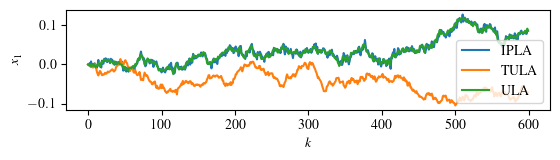

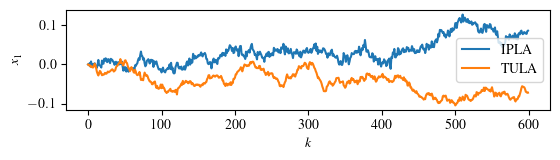

In [19]:
#select Monte Carlo run to draw
mc_draw = 0

# select coordinate to draw
coord_draw = 1

# select time interval to draw
sel1 = 0
sel2 = 600

#plt.style.use(['science'])
plt.rcParams.update({
    "font.family": "serif",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "text.usetex": True,
    } 
    )


plt.figure(figsize=(5.7,1.7))
plt.plot(np.arange(sel1, sel2), samples_ipla[mc_draw, sel1:sel2, coord_draw], label="IPLA")
plt.plot(np.arange(sel1, sel2), samples_tula[mc_draw, sel1:sel2, coord_draw], label="TULA")
plt.plot(np.arange(sel1, sel2), samples_ula[mc_draw, sel1:sel2, coord_draw], label="ULA")
plt.legend()
plt.xlabel("$k$")
plt.ylabel("$x_{"+str(coord_draw)+"}$")
plt.tight_layout()


plt.figure(figsize=(5.7,1.7))
plt.plot(np.arange(sel1, sel2), samples_ipla[mc_draw, sel1:sel2, coord_draw], label="IPLA")
plt.plot(np.arange(sel1, sel2), samples_tula[mc_draw, sel1:sel2, coord_draw], label="TULA")
plt.legend()
plt.xlabel("$k$")
plt.ylabel("$x_{"+str(coord_draw)+"}$")
plt.tight_layout()